In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 999)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.feature_selection import RFECV

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

print("Train data shape: ", train.shape)
print("Test data shape: ", test.shape)

Train data shape:  (1460, 81)
Test data shape:  (1459, 80)


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We have column **YrSold** which is the year the house was sold, it should be have relationship with **SalePrice** column. So we shill explore it

# Data visualization 

In [4]:
plt.style.use(style="ggplot")
plt.rcParams["figure.figsize"] = (10,6)

In [5]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The average price of sale price is  \\$160.000 which is close to the mean \\$180.000 with mot values fall between \\$130.000 and \\$214.000.

Next We will explore the distribution of sale price

Now we use np.log() to transform **SalePrice** and calculate the skewness for the second time, as well as re-plot the data.

SalePrice skew is:  1.8828757597682129


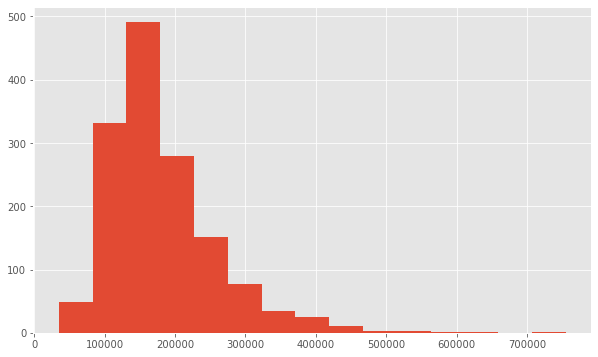

In [6]:
print("SalePrice skew is: ", train["SalePrice"].skew())
plt.hist(train['SalePrice'], bins=15)
plt.show()

Skew is:  0.12133506220520406


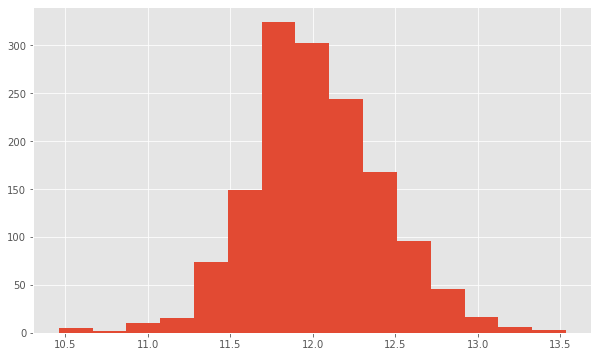

In [7]:
target = np.log(train["SalePrice"])
print("Skew is: ", target.skew())
plt.hist(target, bins=15)
plt.show()

The skew value is getting closer to 0 that means we have improved the skewness of the data

Now we've already transformed target variable. Let's nove on our features

First we check out the numerical features and make some plots.

In [8]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [9]:
corr = numeric_features.corr()
print(corr["SalePrice"].sort_values(ascending=False)[:10], "\n")
print(corr["SalePrice"].sort_values(ascending=False)[-5:])

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


**OverallQual** column has the most positive relationship with **SalePrice**, so we will dig depper on this feature

In [10]:
train["OverallQual"].unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2], dtype=int64)

We will create a pivot table to investigate the relationship between **OverallQual** and **SalePrice**

In [11]:
quality_pivot = train.pivot_table(index="OverallQual", values="SalePrice", aggfunc=np.median)
quality_pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,86250
4,108000
5,133000
6,160000
7,200141
8,269750
9,345000


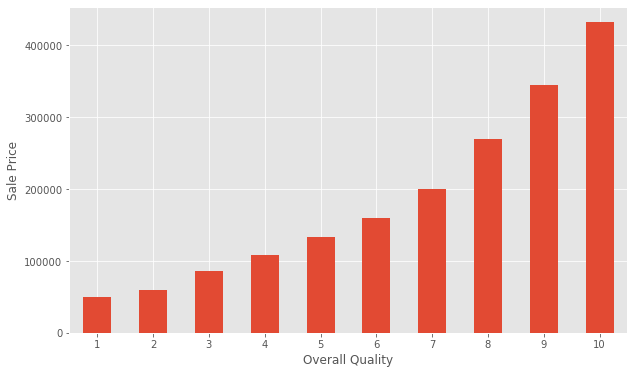

In [12]:
quality_pivot.plot(kind="bar", legend=None)
plt.xlabel("Overall Quality")
plt.ylabel("Sale Price")
plt.xticks(rotation=0)
plt.show()

Notice that the median sales price increases as overall quality increases

Next, we will explore the relationship between **GrLivArea** and **SalePrice**

We will use scatter plot to visualize the relationship between theses columns

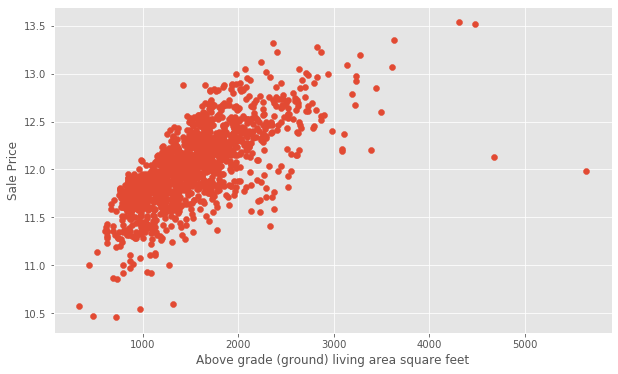

In [13]:
plt.scatter(x=train["GrLivArea"], y=target)
plt.xlabel("Above grade (ground) living area square feet")
plt.ylabel("Sale Price")
plt.show()

At first glance, we can see that the living area increases will make the sale price increases.

We will do the same for **GarageArea** column

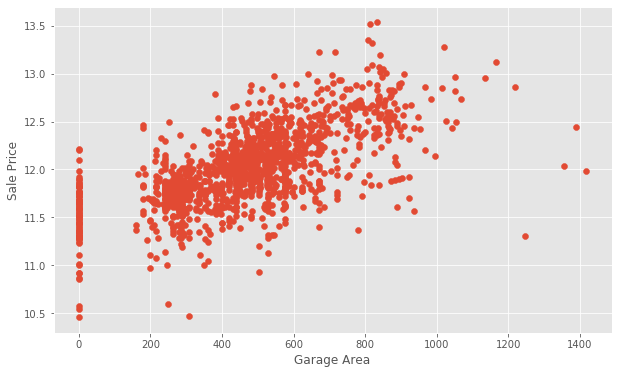

In [14]:
plt.scatter(x=train["GarageArea"], y=target)
plt.xlabel("Garage Area")
plt.ylabel("Sale Price")
plt.show()

We see that there are some house with 0 in **Garage Area**, indicating that they don't have a garage. Also we can notice that there are some outliers, these outliers may affect to out model further. So, we'll remove those observations from out data.

We try to create a new dataframe with outliers removed

In [15]:
train = train[train["GarageArea"] < 1000]

Let's review our plot after removing outliers

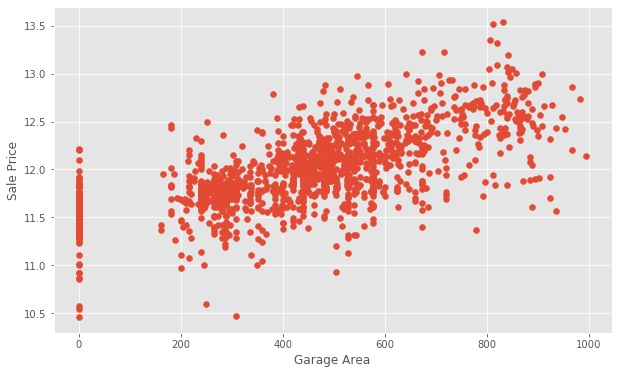

In [16]:
plt.scatter(x=train["GarageArea"], y=np.log(train["SalePrice"]))
plt.xlabel("Garage Area")
plt.ylabel("Sale Price")
plt.show()

Notice that we get a better intuition after removing some outliers from **Garage Area**

# Handling missing values

In [17]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False))[:25]
nulls.columns = ["Null Count"]
nulls.index.name = "Feature"
nulls

,Null Count
Feature,
PoolQC,1439
MiscFeature,1392
Alley,1354
Fence,1165
FireplaceQu,689
LotFrontage,256
GarageCond,81
GarageType,81
GarageYrBlt,81


If we read the description for each feature in **data_description.txt** file we can notice that there are 2 main missing value column types:
- ***Group 1***: Missing values refer to there is no addition feature <br>
  We can will this type of missing value with addition string, in this case, **Zero** can be a choice
- ***Group 2***: Missing values which there is no description about that missing <br>
  We need to find out the relationship of those columns with other columns to fill missing values

In [18]:
fill_with_zero_cols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 
                      "GarageCond", "GarageType", "GarageFinish", "GarageQual", 
                      "BsmtExposure", "BsmtFinType2", "BsmtFinType1", "BsmtCond", "BsmtQual",
                      "MasVnrType"]
missing_cols = ["LotFrontage", "GarageYrBlt", "MasVnrArea", "Electrical"]

## Fill missing values with Zero

In [19]:
train[fill_with_zero_cols] = train[fill_with_zero_cols].fillna("Zero")
test[fill_with_zero_cols] = test[fill_with_zero_cols].fillna("Zero")

Check again to be sure there are only 4 columns remain

In [20]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False))[:6]
nulls.columns = ["Null Counts"]
nulls.index.name = "Features"
nulls

,Null Counts
Features,
LotFrontage,256
GarageYrBlt,81
MasVnrArea,8
Electrical,1
SalePrice,0
ExterCond,0


## Fill other columns

### Electrical

In [21]:
print("Unique values are: ", train["Electrical"].unique())
print("\nMissing values are: ", train["Electrical"].isnull().sum())

Unique values are:  ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]

Missing values are:  1


We will fill this missing value by column mode

In [22]:
print("Mode is: ", train["Electrical"].mode()[0])

Mode is:  SBrkr


In [23]:
train["Electrical"].fillna(train["Electrical"].mode()[0], inplace=True)
test["Electrical"].fillna(test["Electrical"].mode()[0], inplace=True)

### MasVnrArea

If we check the data and description carefully, we can notice that if the value in **MasVnrType** is **NaN** or **None** as written in description, then the value in this column will also be **NaN**.
<br>
Therefore we will fill all missing values in this columns with 0.

In [24]:
train["MasVnrArea"].fillna(0, inplace=True)
test["MasVnrArea"].fillna(0, inplace=True)

### GarageYrBlt

We will treat this column like **MasVnrArea** since if the house doesn't have garage then we won't have the year the garage built.

In [25]:
train["GarageYrBlt"].fillna(0, inplace=True)
test["GarageYrBlt"].fillna(0, inplace=True)

### LotFrontage

We can find out that almost missing values in **LotFrontage** will follow with missing values in **Alley**. But there are some cases that although **Alley** is Graved or Paved, **LotFrontage** still get missing values. There for we will fill this columns by filling missing values as 0 wherever **Alley** also empty and mean value if **Alley** is not empty

In [26]:
def fill_train_lotfrontage(row):
    alley = row["Alley"]
    lft = row["LotFrontage"]
    lft_mean = round(train["LotFrontage"].mean(),2)
    if pd.isnull(lft):
        if pd.isnull(alley):
            return 0
        else:
            return lft_mean
    return lft

def fill_test_lotfrontage(row):
    alley = row["Alley"]
    lft = row["LotFrontage"]
    lft_mean = round(test["LotFrontage"].mean(),2)
    if pd.isnull(lft):
        if pd.isnull(alley):
            return 0
        else:
            return lft_mean
    return lft

In [27]:
train["LotFrontage"] = train.apply(fill_train_lotfrontage, axis=1)
test["LotFrontage"] = test.apply(fill_test_lotfrontage, axis=1)

Check again to be sure there is no column that remains missing values

In [28]:
print("Train null values are: ", train.isnull().sum().sum())
print("Shape of train data: ", train.shape)

Train null values are:  0
Shape of train data:  (1445, 81)


In [29]:
print("Test null values are: ", test.isnull().sum().sum())
print("Shape of test data: ", test.shape)

Test null values are:  22
Shape of test data:  (1459, 80)


Because there are still some columns in test set have missing value, therefore we will fill them by the most common value of each column

## Fill missing values of test set by mode

In [30]:
test_cols = test.columns
for col in test_cols:
    if test[col].isnull().sum() > 0:
        mode = test[col].mode()[0]
        test[col].fillna(mode, inplace=True)

In [31]:
print("Test null values are: ", test.isnull().sum().sum())
print("Shape of test data: ", test.shape)

Test null values are:  0
Shape of test data:  (1459, 80)


Our data is ready to the next step

# Engineering features

## Numeric Features

We will find categorical-like in numeric columns

In [32]:
numeric_cols = train.select_dtypes(include=[np.number])

In [33]:
numeric_unique_values = {
    "Column": [],
    "Unique Values": []
}
for col in numeric_cols.columns:
    numeric_unique_values["Column"].append(col)
    numeric_unique_values["Unique Values"].append(len(train[col].unique()))
numeric_unique_df = pd.DataFrame.from_dict(numeric_unique_values)
numeric_unique_df.sort_values(by="Unique Values")

,Column,Unique Values
18,BsmtHalfBath,3
20,HalfBath,3
19,FullBath,4
17,BsmtFullBath,4
24,Fireplaces,4
22,KitchenAbvGr,4
26,GarageCars,5
36,YrSold,5
33,PoolArea,7
21,BedroomAbvGr,8


Let's get columns which have 24 or less unique values and find the frequency of mode.
If mode of column are greater than 60% entries, we will remove that column

In [34]:
numeric_cateogicals = numeric_unique_df[numeric_unique_df["Unique Values"] <= 24]["Column"]
remove_cols = []
for col in numeric_cateogicals:
    mode_freq = train[col].value_counts(normalize=True).sort_values(ascending=False).iloc[0]
    if mode_freq > 0.6:
        remove_cols.append(col)
print(remove_cols)

['LowQualFinSF', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'MiscVal']


In [35]:
train.drop(remove_cols, axis=1, inplace=True)

## Categorical columns

Let's invest non-numerical columns

In [36]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445,1445
unique,5,2,3,4,4,2,5,3,25,9,8,5,8,6,7,15,16,5,4,5,6,5,5,5,7,7,6,5,2,5,4,7,6,7,4,6,6,3,4,5,5,9,6
top,RL,Pave,Zero,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Zero,Attchd,Unf,TA,TA,Y,Zero,Zero,Zero,WD,Normal
freq,1140,1440,1354,915,1299,1444,1041,1369,225,1248,1431,1207,719,1133,1420,506,495,859,904,1269,635,646,1296,949,424,1241,1413,728,1350,1320,733,1345,689,860,604,1296,1311,1325,1439,1165,1392,1262,1192


Like numeric columns, we also get columns that have frequency of mode less than 60%

In [37]:
enc_cols = []
for col in categoricals.columns:
    mode_freq = train[col].value_counts(normalize=True).sort_values(ascending=False)[:1][0]
    if mode_freq < 0.6:
        enc_cols.append(col)

We will convert these non-numerical columns into numerical

In [38]:
le = preprocessing.LabelEncoder()
for col in enc_cols:
    train["enc_{}".format(col)] = le.fit_transform(train[col])
    test["enc_{}".format(col)] = le.fit_transform(test[col])

In [39]:
train = train.drop(categoricals.columns, axis=1)
test = test.drop(categoricals.columns, axis=1)

In [40]:
corr = abs(train.corr()["SalePrice"]).sort_values(ascending=False).drop(["SalePrice", "Id"])
corr = corr[corr > 0]

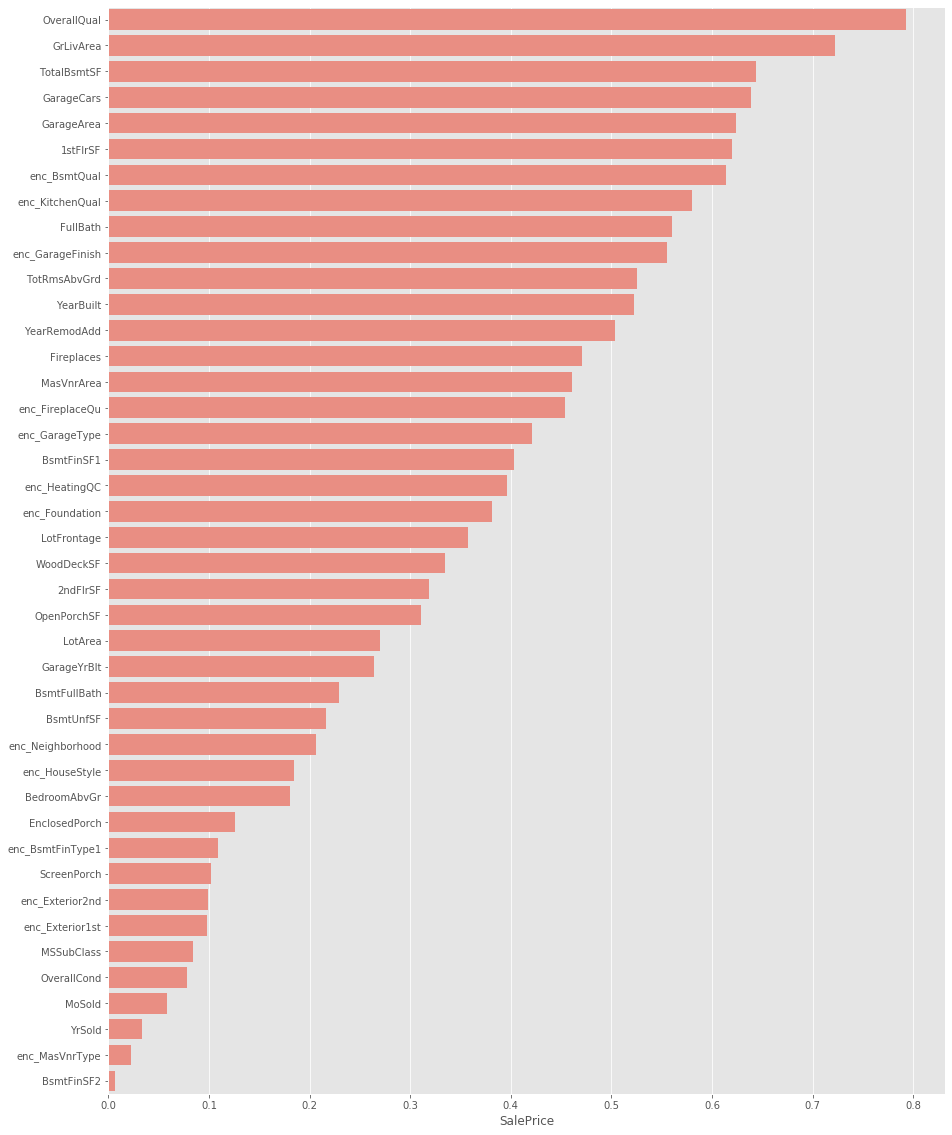

In [41]:
fig = plt.figure(figsize=(15,20))
sns.barplot(corr, corr.index, color="salmon")

In [42]:
features = corr.index
print("Features: ")
features

Features: 


Index(['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'GarageArea',
       '1stFlrSF', 'enc_BsmtQual', 'enc_KitchenQual', 'FullBath',
       'enc_GarageFinish', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       'Fireplaces', 'MasVnrArea', 'enc_FireplaceQu', 'enc_GarageType',
       'BsmtFinSF1', 'enc_HeatingQC', 'enc_Foundation', 'LotFrontage',
       'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea', 'GarageYrBlt',
       'BsmtFullBath', 'BsmtUnfSF', 'enc_Neighborhood', 'enc_HouseStyle',
       'BedroomAbvGr', 'EnclosedPorch', 'enc_BsmtFinType1', 'ScreenPorch',
       'enc_Exterior2nd', 'enc_Exterior1st', 'MSSubClass', 'OverallCond',
       'MoSold', 'YrSold', 'enc_MasVnrType', 'BsmtFinSF2'],
      dtype='object')

In [43]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,YrSold,SalePrice,enc_Neighborhood,enc_HouseStyle,enc_Exterior1st,enc_Exterior2nd,enc_MasVnrType,enc_Foundation,enc_BsmtQual,enc_BsmtFinType1,enc_HeatingQC,enc_KitchenQual,enc_FireplaceQu,enc_GarageType,enc_GarageFinish
count,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000
mean,728.848443,56.871972,69.706408,10436.554325,6.080969,5.579931,1971.035986,1984.707266,100.237370,437.361246,47.032526,565.434602,1049.828374,1155.934256,344.639446,1506.478893,0.423529,1.561246,2.868512,6.495502,0.607612,1867.358478,1.754325,465.945329,93.780623,46.144637,22.182007,14.929412,6.329412,2007.815225,179438.559862,12.224221,3.035986,9.614533,10.329412,1.770934,1.392388,2.317647,2.810381,1.550173,2.351557,3.818685,2.494810,1.291349
std,421.595080,42.291212,21.068267,9906.545843,1.365261,1.112140,30.159733,20.630222,176.279457,430.528008,162.084845,440.194943,415.699117,372.350986,434.427784,509.765672,0.517559,0.548121,0.813246,1.607466,0.642728,455.842734,0.739556,202.904189,125.232497,65.830928,61.394591,55.562677,2.696977,1.330878,77371.323466,6.010572,1.913310,3.205161,3.547774,0.633320,0.723812,0.886651,1.877119,1.741145,0.817659,1.394115,1.936887,0.892544
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,365.000000,20.000000,60.000000,7500.000000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,0.000000,221.000000,794.000000,880.000000,0.000000,1128.000000,0.000000,1.000000,2.000000,5.000000,0.000000,1958.000000,1.000000,326.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000,7.000000,2.000000,8.000000,8.000000,1.000000,1.000000,2.000000,1.000000,0.000000,2.000000,2.000000,1.000000,1.000000
50%,728.000000,50.000000,69.710000,9450.000000,6.000000,5.000000,1972.000000,1993.000000,0.000000,383.000000,0.000000,476.000000,990.000000,1082.000000,0.000000,1456.000000,0.000000,2.000000,3.000000,6.000000,1.000000,1977.000000,2.000000,478.000000,0.000000,24.000000,0.000000,0.000000,6.000000,2008.000000,162000.000000,12.000000,2.000000,12.000000,13.000000,2.000000,1.000000,2.000000,2.000000,0.000000,3.000000,4.000000,1.000000,1.000000
75%,1093.000000,70.000000,79.000000,11512.000000,7.000000,6.000000,2000.000000,2004.000000,161.000000,706.000000,0.000000,806.000000,1291.000000,1383.000000,728.000000,1768.000000,1.000000,2.000000,3.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,8.000000,2009.000000,213000.000000,17.000000,5.000000,12.000000,13.000000,2.000000,2.000000,3.000000,5.000000,4.000000,3.000000,5.000000,5.000000,2.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1474.000000,2336.000000,3206.000000,3228.000000,2065.000000,4676.000000,3.000000,3.000000,8.000000,14.000000,3.000000,2010.000000,4.000000,995.000000,857.000000,547.000000,55

# Linear Regression

In [44]:
y = np.log(train["SalePrice"])
X = train[features]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

In [46]:
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

In [47]:
print("R^2 is: ", lr_model.score(X_test, y_test))

R^2 is:  0.8916730290043674


We get R-squared score approximately 89%, which is good since R-squared value is between 0 and 1, 1 meaning that all of the variance in the target is explained by the data. In general, a higher R-squared means a better fit.

Let's predict our model

In [48]:
predictions = lr_model.predict(X_test)

In [49]:
print("RMSE is: ", mean_squared_error(y_test, predictions))

RMSE is:  0.015511854266044905


Interpret this value is somewhat more intuitive that the R-squared value. The RMSE measures the distance betwene our predicted values and actual values.

We can view this relationship graphically with a scatter plot

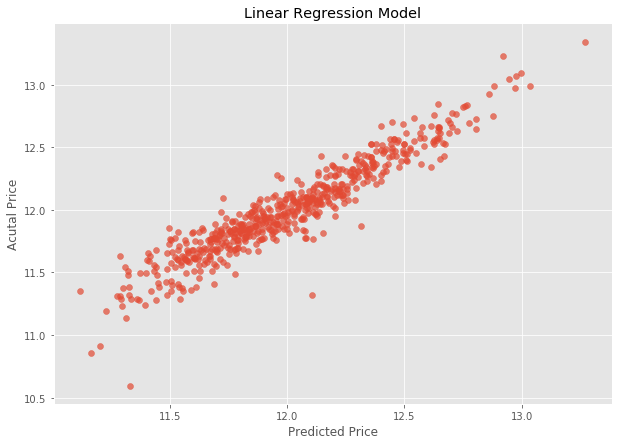

In [50]:
actual_values = y_test
fig = plt.figure(figsize=(10,7))
plt.scatter(predictions, actual_values, alpha=.7)
plt.xlabel("Predicted Price")
plt.ylabel("Acutal Price")
plt.title("Linear Regression Model")
plt.show()

If our predicted values were identical to the actual values, this graph would be the straight line y=x because each predicted value x would be equal to each actual value y.

# Random Forest

In [51]:
rf = RandomForestRegressor()
rf_model = rf.fit(X_train, y_train)

In [52]:
print("R^2 is: ", rf_model.score(X_test, y_test))

R^2 is:  0.8821914451456314


In [53]:
predictions = rf_model.predict(X_test)

In [54]:
print("RMSE is: ", mean_squared_error(predictions, y_test))

RMSE is:  0.01686956736072681


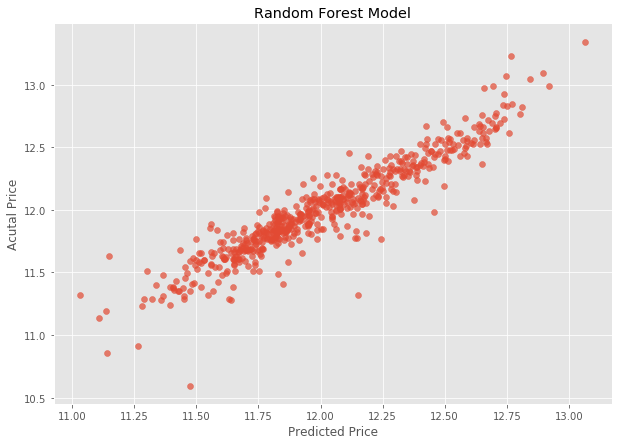

In [55]:
actual_values = y_test
fig = plt.figure(figsize=(10,7))
plt.scatter(predictions, actual_values, alpha=.7)
plt.xlabel("Predicted Price")
plt.ylabel("Acutal Price")
plt.title("Random Forest Model")
plt.show()

# Make a submission 

In [56]:
submission = pd.DataFrame()
submission['Id'] = test['Id']

In [57]:
lr_predictions = lr_model.predict(test[features])

In [58]:
rf_predictions = rf_model.predict(test[features])

Now we'll transform the predictions to the correct form. Remember that to reserve **log()** we do **exp()**.

So we apply **np.exp()** to our predictions because we have taken the logarithm previously.

In [59]:
final_predictions = np.exp(lr_predictions)

In [60]:
print("Original predictions are: \n", predictions[:5], "\n")
print("Final predicctions are: \n", final_predictions[:5], "\n")

Original predictions are: 
 [11.96243775 12.30423784 11.97671771 12.61619337 12.49738185] 

Final predicctions are: 
 [119127.42805955 148983.14436566 173527.3486884  200491.75801467
 181549.44256554] 



Let's assign these predictions and check that everything looks good

In [61]:
submission["SalePrice"] = final_predictions
submission.head()

,Id,SalePrice
0,1461,119127.428060
1,1462,148983.144366
2,1463,173527.348688
3,1464,200491.758015
4,1465,181549.442566


In [62]:
submission.to_csv("submission2.csv", index=False)